In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math
import numdifftools as ndt

# load gas adsorption data

define set of MOFs and gases.

In [36]:
mofs = ["MgMOF74", "HKUST-1"]

gases = ["CH4", 
          "N2", 
         "CO2", 
         "C2H6"
        ]

In [41]:
xtal_density = {"MgMOF74" : 914.87, "HKUST-1": 879.1} # kg/m^3. see compute_density.jl

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07} # g/mol

gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))

read in `.csv` files containing experimental adsorption data from the literature. see the header of the `.csv` for the data source.

In [42]:
isotherm_data = dict()
for mof in mofs:
    isotherm_data[mof] = dict()
    for gas in gases:
        isotherm_data[mof][gas] = pd.read_csv(gas + "_" + mof + ".csv", comment='#')

unit conversions. goal:
* loading: mmol gas / g MOF [keep it in mmol for IAST!]
* pressure: bar

In [43]:
# special cases for each MOF
isotherm_data["MgMOF74"]["N2"]["p(bar)"] = isotherm_data["MgMOF74"]["N2"]["P(kPa)"] * 0.01
isotherm_data["MgMOF74"]["CO2"]["p(bar)"] = isotherm_data["MgMOF74"]["CO2"]["P(mbar)"] * 0.001

isotherm_data["HKUST-1"]["N2"]["p(bar)"] = isotherm_data["HKUST-1"]["N2"]["p(MPa)"] * 10

# where both MOFs need the treatment
for mof in mofs:
    # cm3 STP  *  L STP      *   mol        * 1000mmol
    #  g      1000 cm3 STP    22.4 L STP       1 mol
    isotherm_data[mof]["CH4"]["N(mmol/g)"] = isotherm_data[mof]["CH4"]["cm3/g"] / 22.4

    isotherm_data[mof]["C2H6"]["p(bar)"] = isotherm_data[mof]["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data[mof]["C2H6"]["N(mmol/g)"] = isotherm_data[mof]["C2H6"]["N(cm3STP_cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]
    
# check for success
for mof in mofs:
    for gas in gases:
        try:
            isotherm_data[mof][gas]["N(mmol/g)"]
        except KeyError:
            print("failed unit conversion! mof = ", mof, "gas = ", gas)

plot raw data

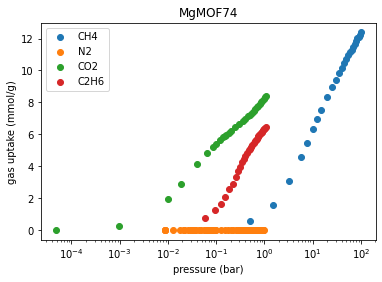

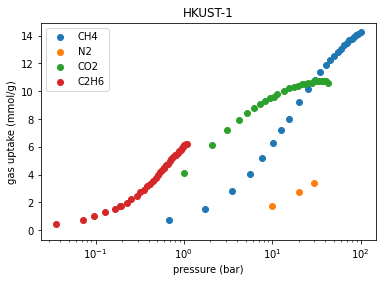

In [48]:
for mof in mofs:
    plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas, color=gas_to_color[gas])
    plt.xscale("log")
    plt.title(mof)
    plt.legend()

fit isotherm models

In [111]:
isotherms = {}
for gas in gases:
    if gas == "CO2" and mof == "MgMOF74":
        model_key = "DSLangmuir"
    elif gas == "C2H6" and mof == "MgMOF74":
        model_key = "Quadratic"
    else:
        model_key = "Langmuir"
    isotherms[gas] = iast.ModelIsotherm(isotherm_data[gas], loading_key="N(mmol/g)", pressure_key="p(bar)", model=model_key)

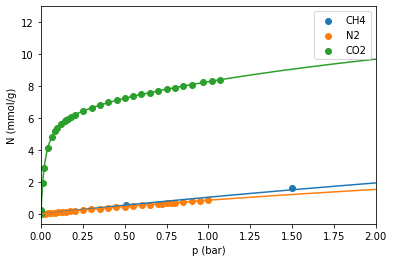

In [113]:
plt.figure()

p_range = np.linspace(0, 2, 1500)

for gas in gases:
    plt.scatter(isotherm_data[gas]["p(bar)"], isotherm_data[gas]["N(mmol/g)"], 
                marker='o', label=gas, color=gas_to_color[gas])
    plt.plot(p_range, isotherms[gas].loading(p_range))
    p_small = np.linspace(0.0, 2.0)
#     plt.plot(p_small, henrys[gas] * p_small, linestyle="--", color=gas_to_color[gas])
plt.xlim(0, p_range[-1])
plt.xlabel("p (bar)")
plt.ylabel("N (mmol/g)")
plt.legend()

In [120]:
def adsorbed_mass(mol_fxns):
    q = iast.iast(mol_fxns, [isotherms[gas] for gas in gases], warningoff=False)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

In [121]:
delta = 0.005
x = np.arange(0.01, 0.3, delta)
y = np.arange(0.01, 0.3, delta)
X, Y = np.meshgrid(x, y)
Z = np.zeros(np.shape(X))
for i in range(np.shape(X)[0]):
    for j in range(np.shape(Y)[1]):
        mol_fxn = [1 - x[i] - y[j], x[i], y[j]]
        Z[j, i] = adsorbed_mass(mol_fxn)

                      Component 1: p^0 = 3.961487 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 5.308265 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 6.638477 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 7.954698 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                 

/home/adrian/.julia/conda/3/lib/python3.8/site-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


                      Component 1: p^0 = 62.313993 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 63.545316 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 64.777792 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 1: p^0 = 66.011463 > 1.000568, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
             

In [116]:
op_pt = np.array([0.7, 0.15, 0.15])
m_op = adsorbed_mass(op_pt)
print("m at op point: ", m_op)
J = ndt.Jacobian(adsorbed_mass, method="forward")
j_op = J(op_pt)[0][1:]
v1, v2 = np.linalg.svd([j_op])[2]

m at op point:  0.2574757812774891


In [117]:
np.linalg.svd([j_op])

(array([[1.]]),
 array([0.33188536]),
 array([[-0.00288622,  0.99999583],
        [ 0.99999583,  0.00288622]]))

In [118]:
# v1, v2 = np.linalg.svd([[henrys[gas] for gas in gases][1:]])[2]

(0.01, 0.295, 0.01, 0.295)

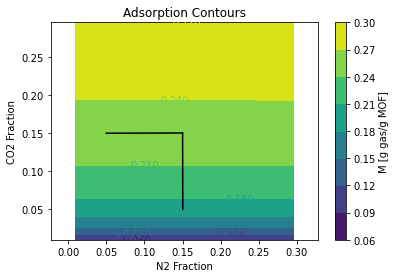

In [119]:
fig, ax = plt.subplots()
CS = ax.contourf(X, Y, Z)
plt.colorbar(CS, label="M [g gas/g MOF]")
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Adsorption Contours')
ax.set_xlabel(gases[1] + " Fraction")
ax.set_ylabel(gases[2] + " Fraction")
plt.plot([op_pt[1], op_pt[1] - v1[0]/10], [op_pt[2], op_pt[2] - v1[1]/10], color='k')
plt.plot([op_pt[1], op_pt[1] - v2[0]/10], [op_pt[2], op_pt[2] - v2[1]/10], color='k')
plt.axis("equal")

In [34]:
def V(x, y, z):
    x, y, z = x[0][0], y[0][0], z[0][0]
    print(x, y, z)
    if x + y + z <= 1:
        return adsorbed_mass([1 - x - y - z, x, y, z])
    else:
        return NaN

In [35]:
X, Y, Z = np.mgrid[0.001:0.003:0.999, 0.001:0.003:0.999, 0.001:0.003:0.999]
X, Y, Z

(array([[[0.001]]]), array([[[0.001]]]), array([[[0.001]]]))

In [36]:
V(X, Y, Z)

[0.001] [0.001] [0.001]
Example use:

              IAST([0.5,0.5], [xe_isotherm, kr_isotherm], verboseflag=true)


Exception: Length of partial pressures != length of array of isotherms...

In [ ]:
from mayavi import mlab
mlab.contour3d(X, Y, Z, V)

In [ ]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

In [ ]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

In [ ]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

In [ ]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

In [ ]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")